#Install detectron2

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=312a739747c03c3de2dbb05021942a9118ffd65d4842844f65d0fb7910480bb3
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-myizfv43
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-myizfv43
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 611kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200617-cp36-none-any.whl size=41031 sha256=93b97f345d759949e0cd6e664f63038d60c9a36f8fa191c90611570f787675a7
  Stored in directory: /root/.cache/pip/wheels/f3/23/28/b223454b61af1187216cff3d681cb39dbe8905808449747ccf
Successfully built fvcore


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

#Prepare the dataset

In [4]:
# download, decompress the data
!wget https://github.com/haneeshb/Face-Mask-Detection/raw/master/facemask.zip
!unzip facemask.zip > /dev/null

--2020-06-17 12:53:38--  https://github.com/haneeshb/Face-Mask-Detection/raw/master/facemask.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/haneeshb/Face-Mask-Detection/master/facemask.zip [following]
--2020-06-17 12:53:38--  https://raw.githubusercontent.com/haneeshb/Face-Mask-Detection/master/facemask.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18519496 (18M) [application/zip]
Saving to: ‘facemask.zip’

facemask.zip        100%[===================>]  17.66M  28.1MB/s    in 0.6s    

2020-06-17 12:53:40 (28.1 MB/s) - ‘facemask.zip’ saved [18519496/18519496]



In [5]:
import pandas as pd
df = pd.read_csv('/content/facemask/train_labels.csv')
df.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0   0-with-mask.jpg    525     350     with_mask   233     7   384   230
1             0.jpg    180     270  without_mask    40     4   131   130
2   1-with-mask.jpg    525     350     with_mask   171     1   434   304
3             1.jpg    154     225  without_mask     2     2   152   189
4  10-with-mask.jpg    233     350     with_mask    46    21   188   202

In [6]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

In [7]:
# write a function that loads the dataset into detectron2's standard format
def get_facemask_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['with_mask', 'without_mask']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['with_mask', 'without_mask']

for d in ["train", "test"]:
  DatasetCatalog.register('facemask/' + d, lambda d=d: get_facemask_dicts('facemask/' + d + '_labels.csv', 'facemask/' + d+'/'))
  MetadataCatalog.get('facemask/' + d).set(thing_classes=classes)
facemask_metadata = MetadataCatalog.get('facemask/train')

We can check if our code works correctly by plotting a few images.

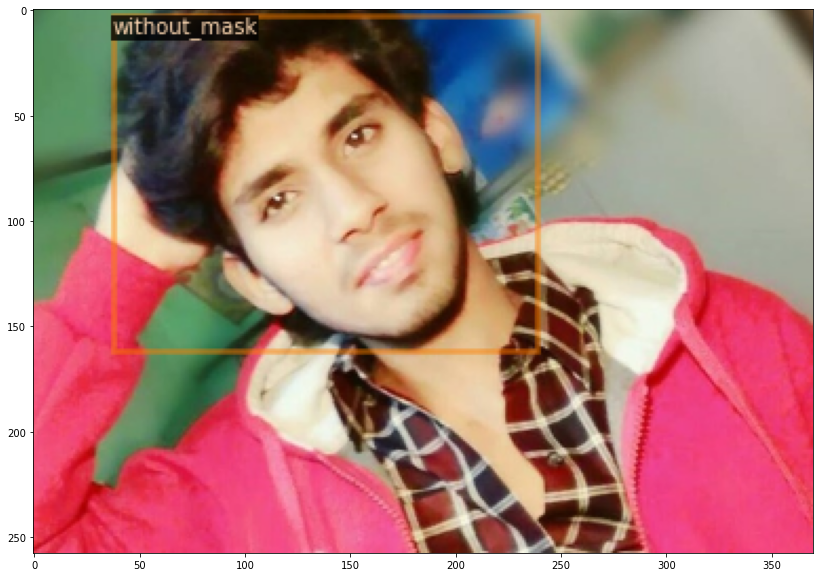

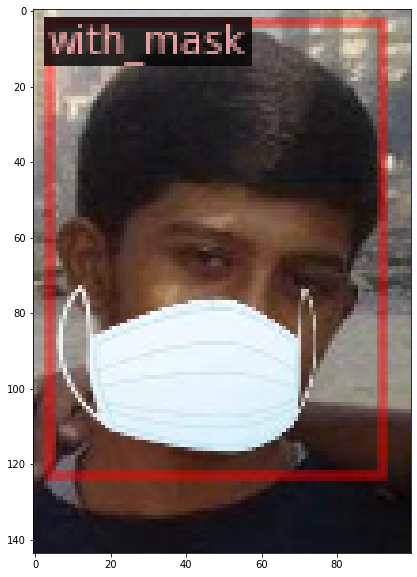

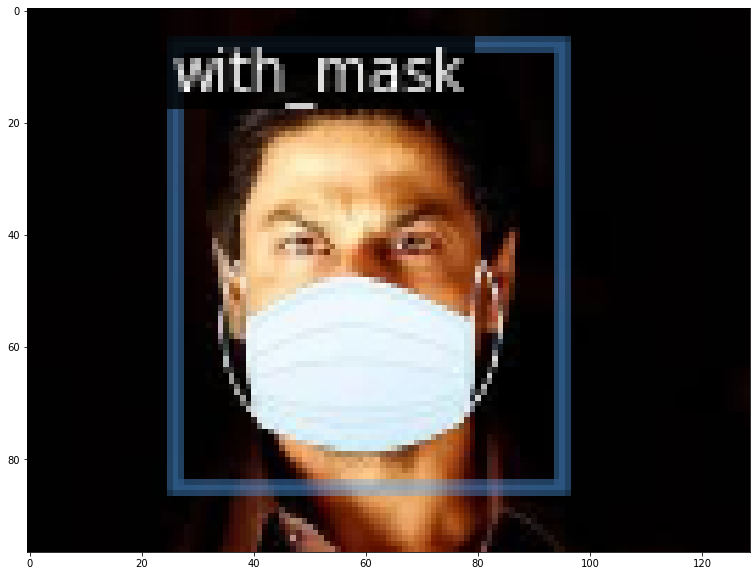

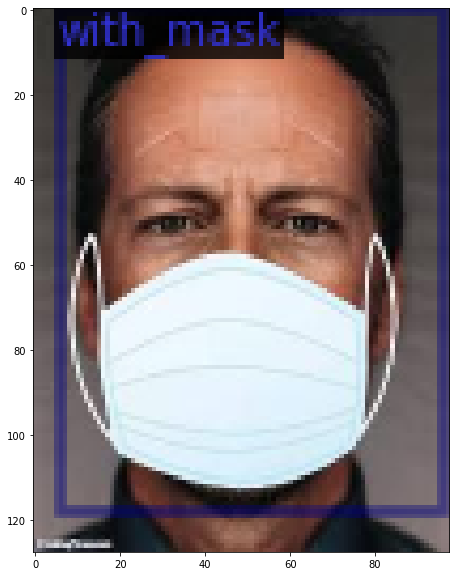

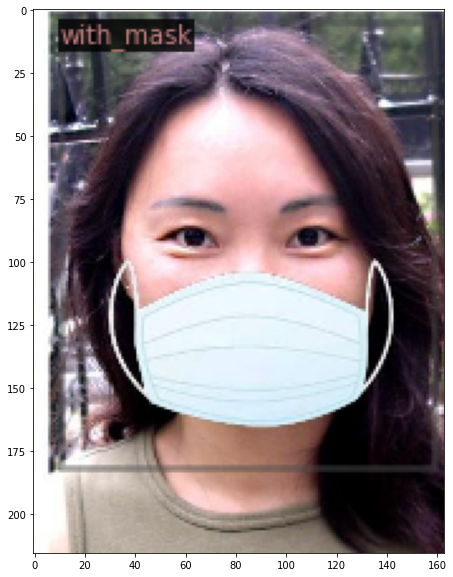

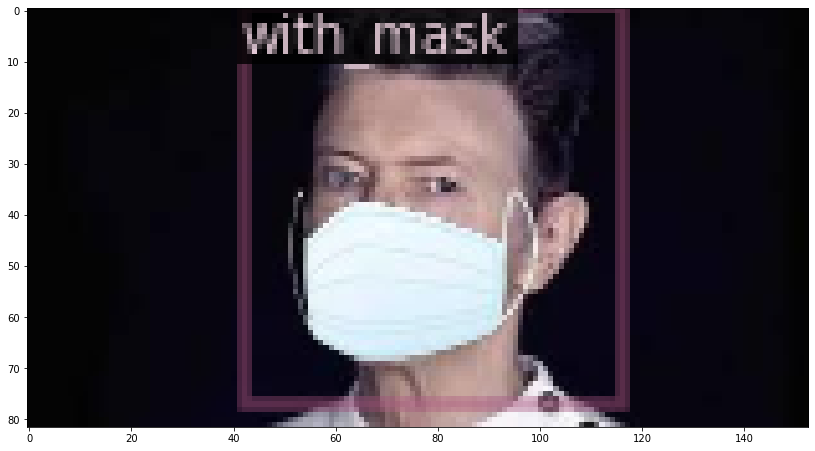

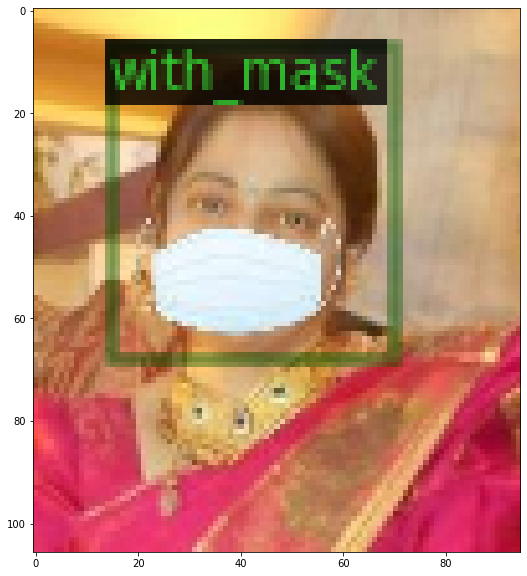

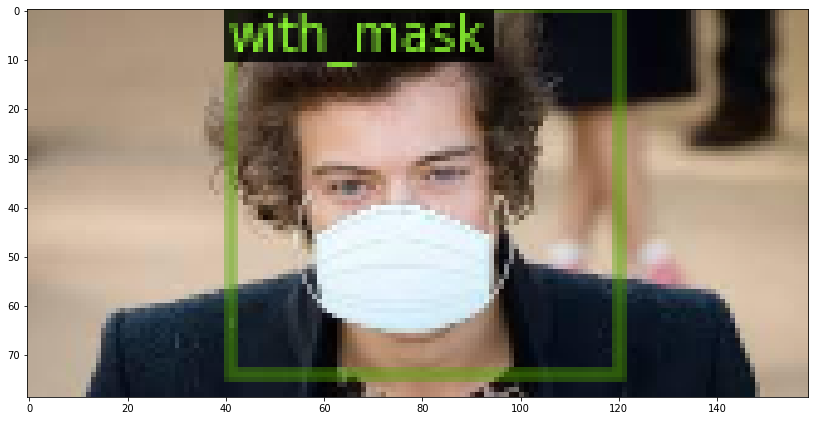

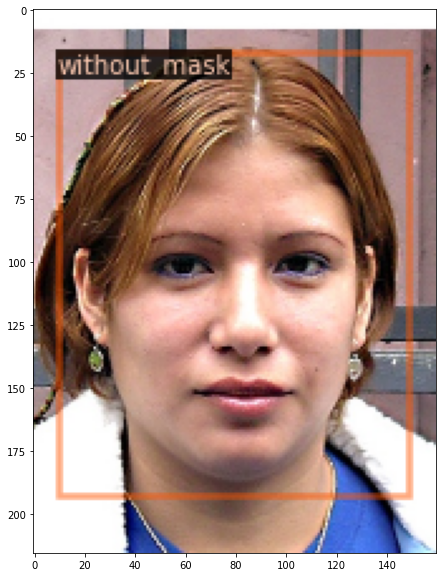

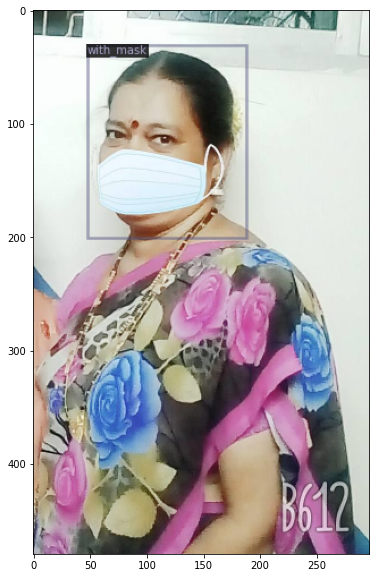

In [9]:
import random
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get('facemask/train')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=facemask_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

#Train model

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import warnings
warnings.filterwarnings('ignore')

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('facemask/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False) #trainer.resume_or_load(resume=False)
trainer.train()

[06/17 12:54:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:11, 20.5MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model!


[06/17 12:54:51 d2.engine.train_loop]: Starting training from iteration 0
[06/17 12:55:28 d2.utils.events]:  eta: 0:14:29  iter: 19  total_loss: 0.635  loss_cls: 0.526  loss_box_reg: 0.100  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  time: 1.8451  data_time: 0.0192  lr: 0.000400  max_mem: 3661M
[06/17 12:56:07 d2.utils.events]:  eta: 0:14:21  iter: 39  total_loss: 0.196  loss_cls: 0.084  loss_box_reg: 0.100  loss_rpn_cls: 0.002  loss_rpn_loc: 0.006  time: 1.8820  data_time: 0.0077  lr: 0.000799  max_mem: 3709M
[06/17 12:56:46 d2.utils.events]:  eta: 0:14:19  iter: 59  total_loss: 0.168  loss_cls: 0.048  loss_box_reg: 0.101  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  time: 1.9164  data_time: 0.0076  lr: 0.001199  max_mem: 3709M
[06/17 12:57:22 d2.utils.events]:  eta: 0:13:15  iter: 79  total_loss: 0.168  loss_cls: 0.051  loss_box_reg: 0.107  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 1.8889  data_time: 0.0071  lr: 0.001598  max_mem: 3709M
[06/17 12:58:00 d2.utils.events]:  eta: 0:12:3

#Use model for inference
Now, we can perform inference on our validation set by creating a predictor object.

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('facemask/test', )
predictor = DefaultPredictor(cfg)

In [12]:
df_test = pd.read_csv('facemask/test_labels.csv')
df_test

filename  width  height         class  xmin  ymin  xmax  ymax
0    100-with-mask.jpg    320     428     with_mask    27    17   310   387
1              100.jpg    320     428  without_mask    23    13   306   383
2    101-with-mask.jpg    320     428     with_mask    32    28   309   395
3              101.jpg    320     428  without_mask    35    27   300   383
4              102.jpg    320     433  without_mask    21    17   314   403
..                 ...    ...     ...           ...   ...   ...   ...   ...
145             97.jpg    327     433  without_mask    38    12   306   379
146   98-with-mask.jpg    459     446     with_mask    28    29   413   432
147             98.jpg    459     446  without_mask    46    27   419   434
148   99-with-mask.jpg    327     433     with_mask    20     3   300   387
149             99.jpg    327     433  without_mask    24    12   302   386

[150 rows x 8 columns]

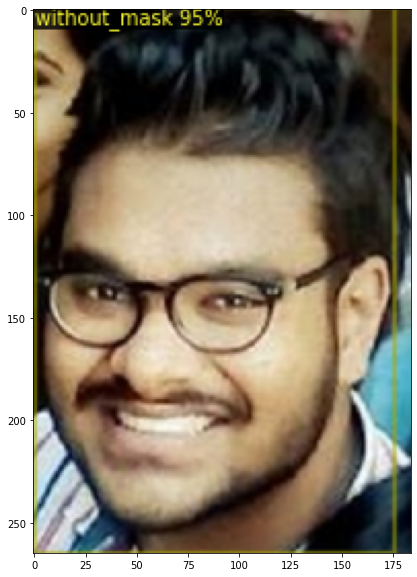

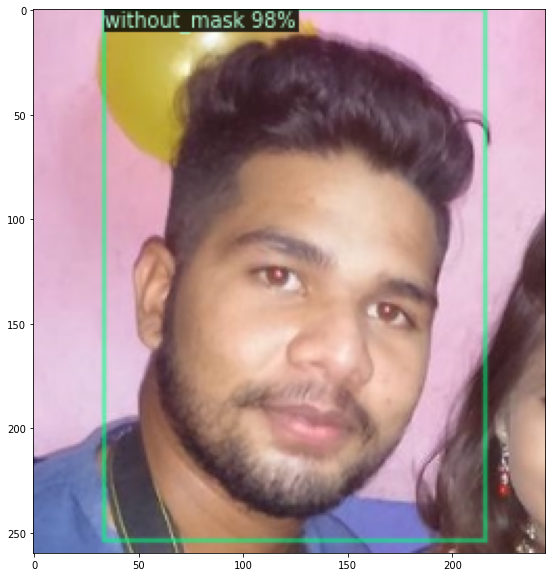

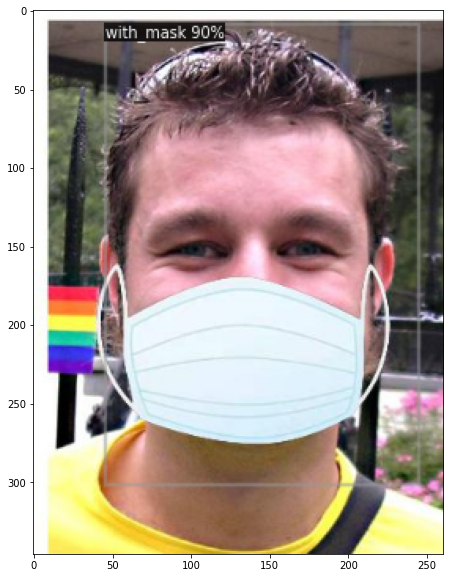

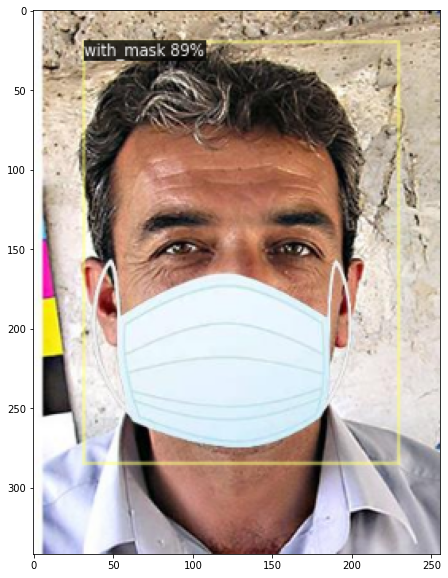

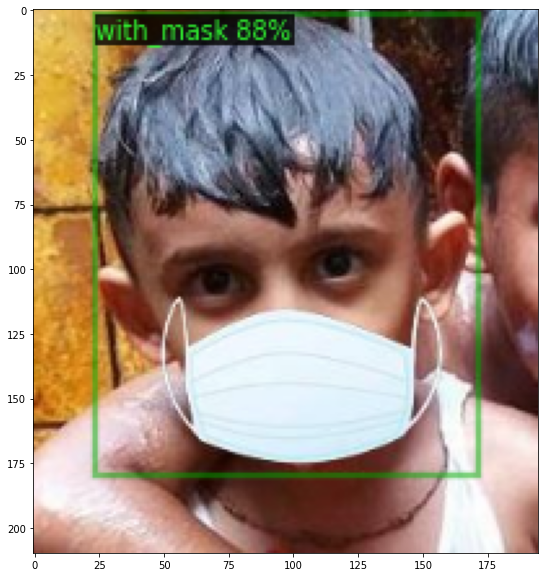

In [13]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('facemask/test')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=facemask_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()